# Word2Vec

Import libaries known to be needed.

In [1]:
import pickle
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

## Get Data:

Data has been saved into pickle files. Need to unpickle, and save as variables in this workbook to work with them.

In [2]:
# Indicate dataframes to import.
list_dfs = ['pickled_conala_mined_df', 'pickled_conala_train_df', 'pickled_conala_test_df',
           'conala_train_bag_df', 'conala_mined_bag_df', 'combined_bag_df']

In [3]:
%time
# Load all data in list_dfs
data = {}
for df in list_dfs:
    dbfile = open(df, 'rb')      
    contents = pickle.load(dbfile)
    data[df] = contents
    dbfile.close()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


## Preprocessing in prep for Word2Vec

For Word2Vec, we need a list of all the sentences which will be transformed in it. So this will have to be done for both intent, and snippet. 

We've discussed maybe combining mined and trained data, but let's start with just the train data first.

In [4]:
df = data["pickled_conala_train_df"]

In [5]:
# Should make a pipeline in the future.
# check for na in the data.
df["rewritten_intent"].isna().sum()

79

79 rows of na. Let's drop them.

In [6]:
# drop the na rows
df.dropna(inplace=True)
# new length of list
print(len(df))

2300


In [7]:
# Create a list of the code snippets in the data. 
snippet_text = list(df["snippet"])
# List of rewritten intent
intent_text = list(df["rewritten_intent"])

In [8]:
# Dependencies for processing the intent_corpus
import re
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/justin.hugh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# Cleaning the text by lowering
processed_intent = [] # Create new list for the resulting text
for i in range(len(intent_text)): # loop through all contents in text list
    processed_intent.append(intent_text[i].lower()) # new list is lowered strings

# check length is same
print(len(processed_intent))
# peek 
print(processed_intent[:11])

2300
["concatenate elements of a list 'x' of multiple integers to a single integer", 'convert a list of integers into a single integer', "convert a datetime string back to a datetime object of format '%y-%m-%d %h:%m:%s.%f'", 'get the average of a list values for each key in dictionary `d`)', 'zip two lists `[1, 2]` and `[3, 4]` into a list of two tuples containing elements at the same index in each list', "prepend string 'hello' to all items in list 'a'", 'regex for repeating words in a string `s`', 'normalize a pandas dataframe `df` by row', 'swap values in a tuple/list inside a list `mylist`', 'swap values in a tuple/list in list `mylist`', 'find all occurrences of the pattern \'\\\\[[^\\\\]]*\\\\]|\\\\([^\\\\)]*\\\\)|"[^"]*"|\\\\s+\' within `strs`']


In [10]:
# further process the intent list, remove special chars
temp_intent = [] # Create new list for the resulting text
for i in range(len(processed_intent)): # loop through all contents in text list
    temp = re.sub('[^a-zA-Z]', ' ', processed_intent[i]) # replace non letters with ' '
    temp_intent.append(temp) # new list is lowered strings
processed_intent = temp_intent # save new processed list
processed_intent

['concatenate elements of a list  x  of multiple integers to a single integer',
 'convert a list of integers into a single integer',
 'convert a datetime string back to a datetime object of format   y  m  d  h  m  s  f ',
 'get the average of a list values for each key in dictionary  d  ',
 'zip two lists          and          into a list of two tuples containing elements at the same index in each list',
 'prepend string  hello  to all items in list  a ',
 'regex for repeating words in a string  s ',
 'normalize a pandas dataframe  df  by row',
 'swap values in a tuple list inside a list  mylist ',
 'swap values in a tuple list in list  mylist ',
 'find all occurrences of the pattern                                        s   within  strs ',
 'generate the combinations of   from a set               ',
 'add multiple columns  hour    weekday    weeknum  to pandas data frame  df  from lambda function  lambdafunc ',
 'beautifulsoup search string  elsie  inside tag  a ',
 'convert a dateti

In [11]:
# further process the intent list, reduce whitespace special chars
temp_intent = [] # Create new list for the resulting text
for i in range(len(processed_intent)): # loop through all contents in text list
    temp = re.sub(r'\s+', ' ', processed_intent[i]) # replace non letters with ' '
    temp_intent.append(temp) # new list is lowered strings
processed_intent = temp_intent # save new processed list
len(processed_intent)

2300

# Import Gensim, and pre-trained Model

In [12]:
# Import Gensim, and get word2vec model methods. 
from gensim.models import Word2Vec
import gensim.downloader # allows downloading of existing models

# Downloading a pre-trained vector using 50 dimensions, from twitter data
wv = gensim.downloader.load('glove-twitter-50')

In [13]:
# Checking vocab type
type(wv.vocab)

dict

In [14]:
# Terms in vocab
len(wv.vocab)

1193514

In [15]:
# Checking for similar terms, cosine similarity!
wv.most_similar("man")

[('boy', 0.8404532670974731),
 ('was', 0.8205661177635193),
 ('bad', 0.819680392742157),
 ('dude', 0.8176411986351013),
 ('he', 0.8076108694076538),
 ('guy', 0.7904506921768188),
 ('god', 0.7806254029273987),
 ('hell', 0.7783043384552002),
 ('problem', 0.7771045565605164),
 ('even', 0.7761484980583191)]

In [16]:
# Check if word is in wv vocab
"cat" in wv.vocab

True

# Set up to try Clustering

In [17]:
len(intent_text)

2300

In [18]:
# A couple of functions to help process lists of text sentences.

def clean_split_text_list(li):
    '''
    Takes a list of sentences.
    Returns a list of lists, each inner list is words in a sentence.
    Also adds a space on either side of non-word, non-digit chars. 
    This allows for brackets, etc. to be considered as their own word, unless 
    vectorized with a model which does not include them.
    '''
    
    new_list = list()
    for i in li:
        if type(i) == float: # recieved errors with handling floats as strings, make into string
            i = str(i)
        if i == None:
            new_list.append(np.zeros_like(wv["empty"])) # If None, empty array of wv shape.
            continue
        try:
            i = i.lower() #lowercase the sentence
        except:
            pass # if cannot be lowered, pass.
        try:
            i = re.sub('([^a-zA-Z\ \d])', r' \1 ', i) # Add spaces between special chars
        except:
            pass
        try:
            i = list(i.split(' '))
        except:
            pass
        new_list.append(i)
    return new_list

def clean_punc(li):
    '''
    Takes a list of sentences, with nested list of words.
    Removes items which are not characters.
    '''
    new_list = list()
    for i in li:
        sub_list = list()
        for j in i:
            try:
                j = re.sub(r'([^a-zA-Z]*)', '', j) # remove non-word chars.
            except:
                pass
            if type(i) == float:
                i = str(i)
            sub_list.append(j)
        new_list.append(sub_list)
    return new_list

def vectorize_text_list(li):
    '''
    Takes a list of lists.
        - first list is a sentence
        - inner list is a list of words.
    Returns a list of lists, each inner list is words in a sentence.
    Also adds a space on either side of non-word, non-digit chars. 
    This allows for brackets, etc. to be considered as their own word, unless 
    vectorized with a model which does not include them.
    '''
    new_list=list() # new list object to be returned at end.
    for i in li:
        # this check is causing issues when it finds an array.
        # so add a try, and another check a level lower? 
        sub_list=list() # list of vecs, representing a sentence
        for j in i: 
            try:
                vec = wv[j]
                sub_list.append(vec)
            except KeyError:
                pass
        new_list.append(sub_list)
    return new_list

In [19]:
%time
vecs = vectorize_text_list(clean_split_text_list(intent_text))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [20]:
vecs[0][0].shape

(50,)

## Creating a Pipeline from the Process

In [57]:
def text_clustering_pipe(li):
    ''' 
    A custom pipline for processing text in prep for clustering techniques.
    
    returns a, b
        where a is a list of arrays (text cleaned)
        where b is a list which is the vocabulary of the input text.
    
    list of sentences -> list of arrays (text cleaned), list vocabulary
    '''
    
    # start with list of sentences - which is the input, 'li'
    
    # Create new list to be returned with processed data.
    processed = [] 
    
    # lowercase the text
    for i in range(len(li)): # loop through all contents in text list
        processed.append(li[i].lower()) # new list is lowered strings
    
    # remove symbols
    temp_list = [] # new var to store 
    for i in range(len(processed)): # loop through all contents
        temp = re.sub('[^a-zA-Z]', ' ', processed[i]) # replace non letters with ' '
        temp_list.append(temp) # new list with symbols replaced.
    processed = temp_intent # after removal, processed is this new list.
    
    # remove extra empty spaces
    temp_list = [] # Create var to store
    for i in range(len(processed)): # loop through all contents in text list
        temp = re.sub(r'\s+', ' ', processed[i]) # remove extra spaces
        temp_list.append(temp) # new list has extra spaces removed strings
    processed_intent = temp_intent # save new processed list
    
    # split text (clean_split_text_list(li))
    processed = clean_split_text_list(processed)
    
    # remove empty chars at end of word lists
    for i in range(len(processed)):
        if (processed[i][-1] == ''): # if last char is ''
            processed[i].pop() # remove last element of list 
    
    # create a vocabulary 
    # create all_words set
    all_words = set()
    for i in range(len(processed)):
        for j in range(len(processed[i])):
            all_words.add(processed[i][j])
            
    # vectorize the text
    processed = vectorize_text_list(processed)
    
    # return the list of of list of arrays
    return processed, list(all_words)

def average_sentences(li):
    ''' 
    list of list of multiple arrays (text cleaned) -> list of arrays (average sentences)
    
    Create target vectors for sentences.
    '''
    # create list to return
    res = []
    
    # loop through list, average the arrays contained.
    for i in range(len(li)):
        sentence_sum=np.zeros(shape=(li[i][0].shape[0]))
        for j in range(len(li[i])):
            sentence_sum += li[i][j]
        res.append(sentence_sum/len(li[i]))
    # return list of arrays (averaged sentences)
    return res

In [58]:
# Testing pipeline functions
li, all_words = text_clustering_pipe(processed_intent)
avg = average_sentences(li)

In [23]:
# Recall how many unique word are in our corpus?
len(all_words)

2112

In [24]:
# Find the list of words contained in model, and those missing.
contained=[] # list of terms in both our corpus and the model
missing=[] # list of terms in our corpus, but not the model
msk=[] # True/false mask for unique words that are in the model. 
for i in all_words:
    if(i in wv.vocab):
        msk.append(1)
        contained.append(i)
    else:
        msk.append(0)
        missing.append(i)
# num words from all_words in the pre-trained model
print(len(contained))
# num words from all_words NOT in the pre-trained model
print(len(missing))

1765
347


now check how many of these are in the word2vec pre-trained model.

# Clustering Models

Import classification models. 

In [25]:
# Unsupervised Learning - Methods
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN

nltk has a clustering library. Let's import it

In [31]:
# Recall the data we'll work with. 

# li is a list of lists in the nested lists, words as vectors from word2vec
print(len(li))
print(li[:3])

2300
[[array([-1.3950e-01, -1.4187e-01, -3.5458e-01,  5.5665e-01,  1.1228e+00,
        4.5506e-01,  4.0499e-01, -9.5999e-01,  1.7275e-02, -7.8436e-01,
       -2.8343e-01,  6.9870e-01, -2.3212e+00,  3.9492e-01, -2.2575e-02,
       -4.1901e-01,  6.4662e-01,  5.0198e-02,  1.0209e+00,  5.6267e-01,
       -9.0100e-01,  7.5304e-02,  3.6705e-01, -7.9209e-01,  1.5528e-03,
        4.4612e-01, -8.1648e-01,  1.1053e+00,  7.3825e-01,  5.4830e-01,
        1.1507e+00, -5.6694e-01,  5.5486e-01, -3.8619e-01,  7.9329e-01,
       -8.7516e-01, -4.8990e-01, -1.8214e-03,  5.5686e-01, -1.5870e-01,
        3.8746e-01,  2.1109e-01,  3.1083e-01, -3.3975e-02, -5.7544e-01,
        4.3238e-03, -1.8273e-01,  4.2901e-01, -5.0816e-03, -9.2379e-02],
      dtype=float32), array([ 0.30221 ,  0.29845 ,  0.42853 ,  0.29232 ,  0.081059,  0.40006 ,
        0.34383 , -0.72365 , -0.81757 , -0.68917 ,  0.48059 , -0.085123,
       -6.3306  ,  0.59362 , -0.24253 , -0.68582 ,  0.76679 ,  0.2537  ,
       -0.022144,  0.1718  , -0

In [34]:
# all_words is the unique words in the input data.
print(len(all_words))
print(all_words[:10])

2112
['decryption', 'mytuple', 'tab', 'marker', 'basename', 'fetch', 'sequences', 'filter', 'bcd', 'cdf']


In [36]:
# avg is the list of the avg word vector for each sentence
print(len(avg))
print(avg[0].shape)
print(avg[:3])

2300
(50,)
[array([ 0.10488167,  0.17831049,  0.1220925 ,  0.38402384,  0.23277065,
        0.12292867,  0.33951415, -0.45165966, -0.21812291, -0.34950634,
       -0.05526692, -0.26288567, -3.70571247,  0.05330725,  0.09177541,
       -0.00479808,  0.35866416, -0.02304291,  0.03795934,  0.15284675,
       -0.19542884,  0.1113615 ,  0.05899217, -0.28523441, -0.12771393,
       -0.07957001, -0.04144642, -0.08332467,  0.02580325,  0.268006  ,
        0.37567116, -0.04378883,  0.12347333, -0.04593917,  0.55538117,
       -0.10932001, -0.07833383,  0.0038488 , -0.27801193, -0.18774658,
       -0.99692669,  0.02181166,  0.0958123 , -0.20007687,  0.11100309,
       -0.17940352, -0.13097583,  0.16509875,  0.02838154, -0.14957534]), array([-1.21841077e-02,  1.66557107e-01,  1.95992226e-01,  5.00193003e-01,
        2.69765428e-01,  9.78851103e-02,  3.28495542e-01, -4.55091217e-01,
       -1.86231222e-01, -2.27120669e-01, -6.24411123e-02, -3.34810116e-01,
       -3.46202780e+00, -1.25298111e-01, 

In [55]:
avg[0]

array([[ 0.10488167,  0.17831049,  0.1220925 ,  0.38402384,  0.23277065,
         0.12292867,  0.33951415, -0.45165966, -0.21812291, -0.34950634,
        -0.05526692, -0.26288567, -3.70571247,  0.05330725,  0.09177541,
        -0.00479808,  0.35866416, -0.02304291,  0.03795934,  0.15284675,
        -0.19542884,  0.1113615 ,  0.05899217, -0.28523441, -0.12771393,
        -0.07957001, -0.04144642, -0.08332467,  0.02580325,  0.268006  ,
         0.37567116, -0.04378883,  0.12347333, -0.04593917,  0.55538117,
        -0.10932001, -0.07833383,  0.0038488 , -0.27801193, -0.18774658,
        -0.99692669,  0.02181166,  0.0958123 , -0.20007687,  0.11100309,
        -0.17940352, -0.13097583,  0.16509875,  0.02838154, -0.14957534]])

In [62]:
avg_df = pd.DataFrame(avg, columns=np.arange(1,51))
avg_df

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
0,0.104882,0.178310,0.122093,0.384024,0.232771,0.122929,0.339514,-0.451660,-0.218123,-0.349506,...,-0.996927,0.021812,0.095812,-0.200077,0.111003,-0.179404,-0.130976,0.165099,0.028382,-0.149575
1,-0.012184,0.166557,0.195992,0.500193,0.269765,0.097885,0.328496,-0.455091,-0.186231,-0.227121,...,-0.756842,-0.038718,0.001044,-0.291439,0.293415,-0.015466,-0.122050,0.269737,-0.023573,-0.038657
2,-0.025589,-0.015593,-0.156561,-0.104549,0.055422,-0.192977,-0.294188,-0.261896,-0.140550,0.039706,...,-1.429231,0.145714,0.193616,-0.009865,0.174343,-0.306418,-0.015563,-0.195466,0.268496,-0.464650
3,0.142781,0.155682,0.167496,0.197694,0.365802,0.064625,0.481282,-0.159876,-0.238490,-0.135767,...,-1.008915,0.061714,-0.042388,-0.187602,0.240048,-0.258838,0.150762,0.011374,-0.081167,0.020506
4,0.045891,0.100924,0.238601,0.149649,0.440140,0.013344,0.559141,-0.267783,-0.158645,-0.375518,...,-0.734394,0.136451,-0.070223,-0.117558,0.250323,-0.215368,0.047803,-0.194729,-0.016005,0.201203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,0.490654,0.116945,-0.118746,-0.015324,0.564240,-0.123475,0.803541,-0.216413,0.036919,-0.434776,...,-0.528842,0.047215,0.009166,-0.185481,0.185632,-0.460274,-0.253634,-0.170659,0.185230,0.218924
2296,0.191950,-0.011363,-0.170825,0.258434,0.083059,-0.235671,0.626758,-0.243607,-0.076812,0.134891,...,-0.808798,-0.055081,-0.114594,-0.235413,0.081134,-0.026538,-0.051872,0.263978,-0.073919,-0.090242
2297,-0.054163,0.246176,-0.081870,0.035172,0.064841,0.029441,0.176820,-0.415572,-0.062583,-0.423305,...,-0.588471,0.046755,-0.096233,-0.149938,0.349339,0.316533,-0.034334,0.243312,0.172953,-0.111491
2298,0.068137,0.070002,-0.217769,-0.054112,-0.047195,0.121455,-0.011126,-0.060107,-0.091401,-0.383751,...,-0.414044,0.303117,0.057181,0.033829,0.144977,-0.063516,-0.082007,-0.234997,0.267006,-0.158077


In [63]:
from nltk.cluster import KMeansClusterer
import nltk

In [64]:
NUM_CLUSTERS=10
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
                             repeats=25)

In [65]:
X = avg_df
X.shape

(2300, 50)

### KMeans Clustering

In [71]:
# Specify
kmeans = KMeans(n_clusters=8)
# Fit to data
kmeans.fit(X)

In [72]:
pred_labels = kmeans.predict(X)

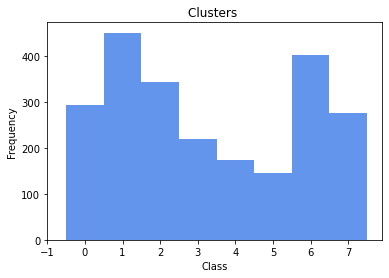

In [94]:
# Some matplot lib trickery to plot a histogram with
# discrete classes.
bins = np.arange(0, pred_labels.max() + 1.5) - 0.5
fig, ax = plt.subplots()
_ = ax.hist(pred_labels, bins, color='cornflowerblue')
ax.set_xticks(bins - 0.5)
plt.title("Clusters ")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


Now loop through models, and compare silhouette scores. 

Try other models.

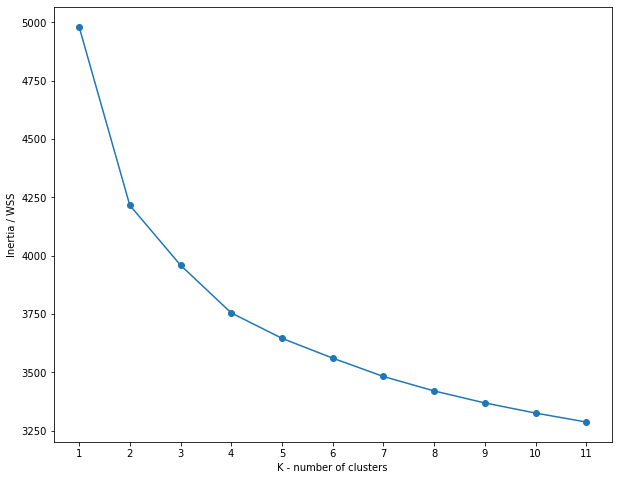

In [98]:
# For each k 
ks = range(1, 12)
inertias = list()

for k in ks:
    # Instantiate
    kmeans = KMeans(n_clusters=k)
    
    # Fit the kmeans model (to the entire X data)
    kmeans.fit(X)

    # Calculate inertia
    inertias.append(kmeans.inertia_)
    
# Plot the result
plt.figure(figsize=(10,8))
plt.plot(ks, inertias, marker='o')
plt.xticks(ks)
plt.xlabel('K - number of clusters')
plt.ylabel('Inertia / WSS')
plt.show()

In [117]:
from sklearn.metrics import silhouette_score
ks = range(2,12)
km_silhouette_scores = []

for k in ks:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    
    my_silhouette_score = silhouette_score(X, kmeans.predict(X))
    km_silhouette_scores.append(my_silhouette_score)
    print(f"The silhouette score with {k} clusters is: {round(my_silhouette_score, 2)}")

The silhouette score with 2 clusters is: 0.16
The silhouette score with 3 clusters is: 0.1
The silhouette score with 4 clusters is: 0.08
The silhouette score with 5 clusters is: 0.08
The silhouette score with 6 clusters is: 0.07
The silhouette score with 7 clusters is: 0.06
The silhouette score with 8 clusters is: 0.06
The silhouette score with 9 clusters is: 0.05
The silhouette score with 10 clusters is: 0.05
The silhouette score with 11 clusters is: 0.05


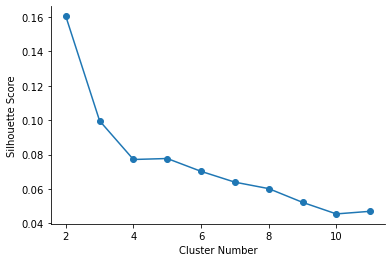

In [118]:
plt.figure()
plt.plot(ks, km_silhouette_scores, marker="o")
plt.xlabel("Cluster Number")
plt.ylabel("Silhouette Score")
sns.despine()
plt.show();

These results seem to indicate that the clustering is not doing a great job of splitting up the intents in our data.

In [155]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([ 890, 1410]))

In [156]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 643,  600, 1057]))

In [158]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([426, 773, 630, 471]))

In [160]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([245, 155, 118, 154, 270, 146, 254, 311, 280, 367]))

### Mixture Model Clustering

In [106]:
from sklearn.mixture import GaussianMixture

#Build and fit the model
gmm = GaussianMixture(n_components=8, covariance_type='full')
gmm.fit(X)

#Getting the labels
gmm_pred_labels = gmm.predict(X)

In [107]:
gmm_pred_labels

array([6, 6, 7, ..., 4, 7, 7])

In [113]:
# For each n 
ns = range(2, 12)
gm_silhouette_scores = []

for n in ns:
    gmm = GaussianMixture(n_components=n, covariance_type='full')
    gmm.fit(X)
    
    # Score
    my_silhouette_score = silhouette_score(X, gmm.predict(X))
    gm_silhouette_scores.append(my_silhouette_score)
    print(f"The silhouette score with {n} components is: {round(my_silhouette_score, 2)}")

The silhouette score with 2 components is: 0.1
The silhouette score with 3 components is: 0.04
The silhouette score with 4 components is: 0.03
The silhouette score with 5 components is: 0.03
The silhouette score with 6 components is: 0.02
The silhouette score with 7 components is: 0.02
The silhouette score with 8 components is: 0.02
The silhouette score with 9 components is: 0.01
The silhouette score with 10 components is: 0.02
The silhouette score with 11 components is: 0.02


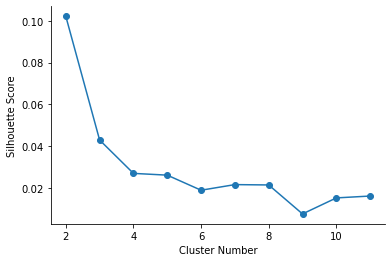

In [114]:
plt.figure()
plt.plot(ns, gm_silhouette_scores, marker="o")
plt.xlabel("Cluster Number")
plt.ylabel("Silhouette Score")
sns.despine()
plt.show();

### Agglom Model Clustering

In [122]:
from sklearn.cluster import AgglomerativeClustering
ns = range(2, 12)
agg_silhouette_scores = []

for n in ns:
    agg = AgglomerativeClustering(n_clusters=n, linkage='average')
    agg.fit(X)
    
    # Score
    my_silhouette_score = silhouette_score(X, agg.labels_)
    agg_silhouette_scores.append(my_silhouette_score)
    print(f"The silhouette score with {n} clusters is: {round(my_silhouette_score, 2)}")

The silhouette score with 2 clusters is: 0.49
The silhouette score with 3 clusters is: 0.43
The silhouette score with 4 clusters is: 0.4
The silhouette score with 5 clusters is: 0.36
The silhouette score with 6 clusters is: 0.36
The silhouette score with 7 clusters is: 0.35
The silhouette score with 8 clusters is: 0.31
The silhouette score with 9 clusters is: 0.26
The silhouette score with 10 clusters is: 0.24
The silhouette score with 11 clusters is: 0.24


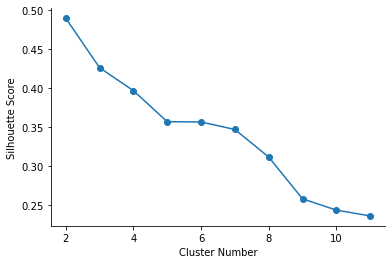

In [123]:
plt.figure()
plt.plot(ns, agg_silhouette_scores, marker="o")
plt.xlabel("Cluster Number")
plt.ylabel("Silhouette Score")
sns.despine()
plt.show();

In [122]:
from sklearn.cluster import AgglomerativeClustering
ns = range(2, 12)
agg_silhouette_scores = []

for n in ns:
    agg = AgglomerativeClustering(n_clusters=n, linkage='average')
    agg.fit(X)
    
    # Score
    my_silhouette_score = silhouette_score(X, agg.labels_)
    agg_silhouette_scores.append(my_silhouette_score)
    print(f"The silhouette score with {n} clusters is: {round(my_silhouette_score, 2)}")

The silhouette score with 2 clusters is: 0.49
The silhouette score with 3 clusters is: 0.43
The silhouette score with 4 clusters is: 0.4
The silhouette score with 5 clusters is: 0.36
The silhouette score with 6 clusters is: 0.36
The silhouette score with 7 clusters is: 0.35
The silhouette score with 8 clusters is: 0.31
The silhouette score with 9 clusters is: 0.26
The silhouette score with 10 clusters is: 0.24
The silhouette score with 11 clusters is: 0.24


In [161]:
for n in ns:
    agg = AgglomerativeClustering(n_clusters=n, linkage='average')
    agg.fit(X)
    print(np.unique(agg.labels_, return_counts=True))

(array([0, 1]), array([2297,    3]))
(array([0, 1, 2]), array([2296,    3,    1]))
(array([0, 1, 2, 3]), array([2295,    3,    1,    1]))
(array([0, 1, 2, 3, 4]), array([   3,    7,    1,    1, 2288]))
(array([0, 1, 2, 3, 4, 5]), array([   7, 2288,    1,    1,    2,    1]))
(array([0, 1, 2, 3, 4, 5, 6]), array([2288,    6,    1,    1,    2,    1,    1]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2284,    4,    1,    6,    2,    1,    1,    1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([2283,    4,    1,    6,    2,    1,    1,    1,    1]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([   4, 2280,    1,    6,    3,    1,    1,    1,    1,    2]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([2280,    6,    1,    2,    3,    1,    1,    1,    1,    2,    2]))


### DBSCAN Clustering

In [138]:
from sklearn.cluster import DBSCAN
eps_range = range(2, 12)
dbscan_silhouette_scores = []

for index, eps_i in enumerate([1, 1.25, 1.5, 2, 2.5]):
    dbscan = DBSCAN(eps=eps_i, min_samples=2)
    dbscan.fit(X)
    
    # Score
    my_silhouette_score = silhouette_score(X, dbscan.labels_)
    dbscan_silhouette_scores.append(my_silhouette_score)
    print(f'For eps: {eps_i}')
    print(f"The silhouette score with {n} clusters is: {round(my_silhouette_score, 2)}")
    print(f'number of noise points: {np.sum(dbscan.labels_ < 0)}')

For eps: 1
The silhouette score with 2 clusters is: -0.14
number of noise points: 766
For eps: 1.25
The silhouette score with 2 clusters is: -0.07
number of noise points: 269
For eps: 1.5
The silhouette score with 2 clusters is: 0.11
number of noise points: 76
For eps: 2
The silhouette score with 2 clusters is: 0.41
number of noise points: 7
For eps: 2.5
The silhouette score with 2 clusters is: 0.43
number of noise points: 3


In [152]:
dbscan = DBSCAN(eps=1, min_samples=2)
dbscan.fit(X)
np.unique(dbscan.labels_, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122]),
 array([ 766, 1223,    3,    3,    3,    2,    4,    3,    2,    2,    3,
           2,    2,    2,    2,    2,    2,    2,    4,    3,    2,    2,
           4,    2,    3,    2,    3,    2,    2,    2,    2,    2,    3,
           2,    2,    2,    3,    2,    2,    2,    2,    4,    2,    3,
  

In [154]:
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan.fit(X)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7]),
 array([  76, 2208,    2,    2,    2,    4,    2,    2,    2]))

This shows us that the clustering is not working so great with DBSCAN. Our key distinction here is essentially whether or not something is noise.

### Compare Clustering Scores

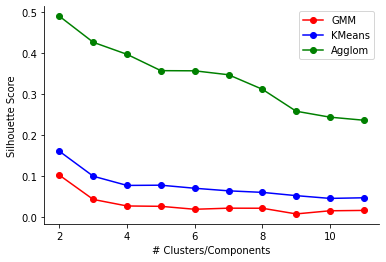

In [162]:
plt.figure()

plt.plot(ns, gm_silhouette_scores, marker="o", color='red', label="GMM")
plt.plot(ks, km_silhouette_scores, marker="o", color='blue', label="KMeans")
plt.plot(ns, agg_silhouette_scores, marker="o", color = 'green', label="Agglom")
plt.xlabel("# Clusters/Components")
plt.ylabel("Silhouette Score")
plt.legend()
sns.despine()
plt.show();

## Classifier on Clustered Labels

Having tried four different modelling approaches on the data above, there's a lot to digest in the results so far.

In short, the KMeans model seems to be the most promising (even with a pretty low silhouette score). We can summarize the results below: 

KMeans: 
- low silhouette scores
- separation is not helped by increase number of clusters. 
- BUT, the cluster predictions are relatively evenly distributed. 

GMM: 
- Poorest performing in silhouette scores.
- separation not helped by increase in number of clusters. 
- cluster predictions are NOT well distributed. Almost all in one cluster.

Agglom: 
- Appears to be the best performing by far in terms of sihluette scores. 
- separation not helped by increase in number of clusters
- cluster predictions are NOT well distributed. Almost all in one cluster.

DBSCAN: 
- Noise is either a large proportion, or hard to remove
- Creates a large number of clusters with large eps, which is not helpful to us. 
- Cluster predictions are NOT well distributed. Almost all in one cluster (or noise). 

These results shouldn't be too surprising. 
- Since we used a pretrained word2vec model, and since most of our vocabulary revolves around coding language, it makes sense that they will have very similar vectors, and therefore are hard to separate.
- KMeans algorithm essentially draws straight line separators in the data, so althought we have a more even class distribution, this may be at the cost of separation score, and interprability.

POSSIBLE NEXT STEP: 
- With the predicted KMeans labels, train a set of classifiers, and see how they perform. 
    -then comment on the performance and meaning of the clustering.
    - consider scaling on the vectors! KMeans uses a euclidian distance in its algorithm so this will affect the separation of the clusters. 